In [1]:
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_local
from skimage.feature import SIFT
import numpy as np
import pathlib
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Playground

In [2]:
img = "../data/final/images/2008_005380.jpg"
image = plt.imread(img)
plt.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: '../data/final/images/2008_005380.jpg'

## Thresholding

In [115]:
image.shape

(500, 333)

In [120]:
image = cv2.imread(img)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
th_otsu = cv2.threshold(image, 127, 255, cv2.THRESH_OTSU)

In [125]:
th_otsu[1]

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [91]:
image_grey[image_grey <= th_otsu]

array([0.16360627, 0.17057059, 0.16614392, ..., 0.51161843, 0.48805843,
       0.57239137])

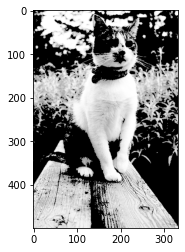

In [106]:
image_grey = np.where(image_grey > th_otsu, image_grey, 0)
plt.imshow(image_grey, cmap="gray")

In [107]:
descriptor_extractor = SIFT()

In [108]:
descriptor_extractor.detect_and_extract(image_grey)

## Implementing Hessian affine detector

In [94]:
image_grey = rgb2gray(image)

In [98]:
from skimage.filters import hessian

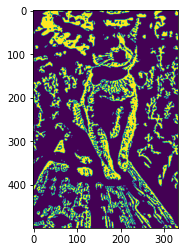

In [105]:
plt.imshow(hessian(image_grey)>.9)

# Preparing features
## Compute SIFT descriptors

In [3]:
def return_descriptors(img, proportion=0.8, random_state=42):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    values = [keypoint.response for keypoint in kp]
    order = sorted(range(len(values)), key=lambda i:values[i])
    des = des[order, :]
    return des[:int(len(des)*proportion), :]

In [6]:
DATA_PATH = pathlib.Path("../data/interim")
IMAGES_PATH = DATA_PATH / "images"

In [7]:
proportion = 0.8
descriptors = []
for image_name in tqdm(os.listdir(IMAGES_PATH)):
    image = cv2.imread((IMAGES_PATH / image_name).__str__())
    desc = return_descriptors(image, proportion)
    for d in desc:
        descriptors.append(d)

100%|██████████| 742/742 [01:01<00:00, 12.06it/s]


In [8]:
descriptors = np.array(descriptors)

In [9]:
descriptors.shape

(451946, 128)

## Classifying descriptors

In [126]:
from sklearn.cluster import KMeans
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters)
#kmeans.fit(descriptors)

In [127]:
kmeans.n_clusters

50

In [8]:
def get_features(img, proportion, n_clusters, random_state):
    desc = return_descriptors(img, proportion, random_state)
    predictions = kmeans.predict(desc)
    hist, _ = np.histogram(predictions, range=(0, n_clusters), bins=n_clusters)
    return hist

In [9]:
dataset = dict()
for image_name in tqdm(os.listdir(IMAGES_PATH)):
    image = cv2.imread((IMAGES_PATH / image_name).__str__())
    dataset[image_name] = get_features(image, proportion, n_clusters, 42)

100%|██████████| 2308/2308 [01:13<00:00, 31.40it/s]


In [10]:
df = pd.DataFrame(dataset).T.reset_index()

In [11]:
df.head()

,index,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,2009_002273.jpg,74,6,18,20,9,11,33,17,10,...,9,6,23,6,11,7,31,8,12,9
1,2008_005174.jpg,2,6,3,4,14,16,21,4,4,...,1,3,8,5,11,5,30,23,3,9
2,2008_007777.jpg,3,12,6,5,6,14,15,7,7,...,6,6,19,11,8,11,9,3,15,8
3,2008_003511.jpg,1,15,5,4,3,10,27,9,8,...,10,12,17,4,6,5,48,16,10,10
4,2009_002267.jpg,1,1,4,3,3,2,2,2,4,...,6,3,3,2,1,0,1,1,4,0


## Prepare dataset

In [12]:
labels = pd.read_csv(DATA_PATH / "labels.csv")

In [13]:
final_df = pd.merge(df, labels, left_on="index", right_on="path").drop(["path", "index"], axis=1)

In [14]:
X = final_df.drop("label", axis=1)
y = final_df["label"]

In [15]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)

In [16]:
X_scaled = scaler.transform(X)

# Classification
## Logistic Regression

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=1/3, random_state=42)

In [18]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(max_iter=1000, Cs=20)
lr.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, max_iter=1000)

In [19]:
lr.score(X_train, y_train)

0.6469440832249674

In [20]:
lr.score(X_test, y_test)

0.5948051948051948

## SVM

In [54]:
from sklearn.svm import SVC
svc = SVC(C=1)
svc.fit(X_train, y_train)

SVC(C=1)

In [56]:
svc.score(X_train, y_train)

0.7340702210663199

In [57]:
svc.score(X_test, y_test)

0.612987012987013

## Random Forests

In [24]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
rfc.score(X_train, y_train)

1.0

In [26]:
rfc.score(X_test, y_test)

0.6077922077922078